<a href="https://colab.research.google.com/github/brontominds/bounce_demand/blob/v0.01/DemandPredictionPythonModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam,SGD,RMSprop,Adagrad



#Add date time specific columns to the dataframe
def datetime(df):
  from datetime import datetime
  df['datetime'] = pd.to_datetime(df['datetime'])
  df['year'] = df['datetime'].dt.year
  df['month']=df['datetime'].dt.month
  df['day'] = df['datetime'].dt.day 
  df['hour'] = df['datetime'].dt.hour
  df['dayofweek'] = df['datetime'].dt.dayofweek
  return df

#Normalize a column of dataframe and return mean and sd
def normalize(df,feature_name):
  mean_value = df[feature_name].mean()
  std_value = df[feature_name].std()
  df[feature_name] = (df[feature_name] - mean_value) / std_value        
  return (df, mean_value, std_value)


#One hot encode data
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

#Drop Redundant Columns
def drop_redundantcolumns(data):
  return (data.drop(["casual","registered"], axis=1))  

#Create target variable and convert features dataframe to a numpy array
def create_targetvariable(data, fraction=0.2):
    data_y = data["count"]
    data_x = data.drop(["count"], axis=1)
    return data_x.values, data_y




In [0]:
%matplotlib inline
def plotOutliers(df):
  plt.figure(1)
  plt.subplot(121)
  sns.distplot(df); 
  plt.subplot(122)
  df.plot.box(figsize=(16,5)) 
  plt.show()

In [0]:
#Read Training Data
data=pd.read_csv("train.csv")
data_original=data

#Add new features of date time
data=datetime(data)
data=data.drop('datetime',axis=1)



In [0]:
#Plot graphs if required
#plotOutliers(data['atemp'])

In [0]:
#Transform Data
#Normalize weather data
data, mean_temp, sd_temp=normalize(data,["temp"])
data,mean_atemp,sd_atemp=normalize(data,["atemp"])
data,mean_humidity,sd_humidity=normalize(data,["humidity"])
data,mean_windspeed,sd_windspeed=normalize(data,["windspeed"])

#One hot-encode categorical data
data = dummy_data(data, ["season","weather","hour","dayofweek","month"]) #"day" not included because of incomplete data
#TODO: Check which all features require hot encoding, and which work better without hot encoding

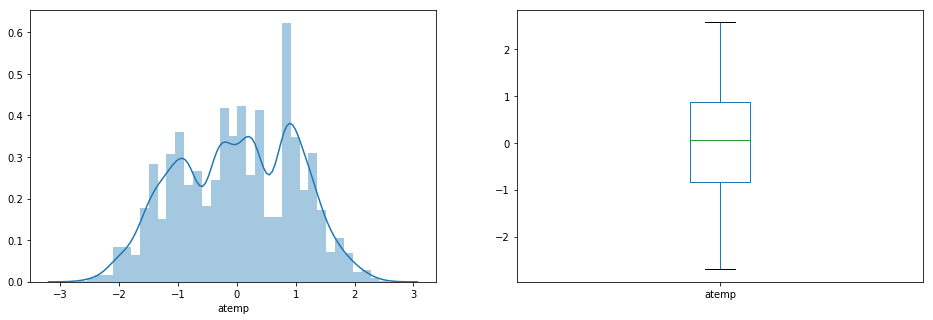

In [0]:
#Shuffle data and split into training+validation, and testing
#Training and Validation data kept together as Keras will do the auto split
data=shuffle(data,random_state=1) #Seed=1 applied for ability to repeat same tests with parameters tuning

testDataSplit=0 #0.3 means 30% data will be taken out for test and remaining for training+validation
nrows = len(data)
training_validation_rows = int(nrows*(1-testDataSplit))
training_validation_data=data[0:training_validation_rows-1]
test_data=data[training_validation_rows:]

In [0]:
#Drop casual and registered users columns
training_validation_data = drop_redundantcolumns(training_validation_data)

#Separate target variable, and convert features data into a numpy array
data_x, data_y = create_targetvariable(training_validation_data)

In [0]:
#Generate NN Sequential Model
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = data_x.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='softplus'))

#Define optimizer
adam = Adam(lr=1e-3, decay=1e-3 / 200)

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['mean_absolute_error','mean_squared_error'])
#NN_model.summary()

In [0]:
#Define callbacks for model training
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose =1, save_best_only = True, mode ='auto')
early_stop=EarlyStopping(monitor='val_loss',patience=10)
callbacks_list = [checkpoint,early_stop]

In [0]:
#Define plot function to show training and validation losses
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()

In [0]:
#TRAIN MODEL
history=NN_model.fit(data_x, data_y, epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 8708 samples, validate on 2177 samples
Epoch 1/1000
8708/8708 [==============================] - 2s 214us/step - loss: 2.1842 - mean_absolute_error: 143.6277 - mean_squared_error: 41780.7941 - val_loss: 2.0549 - val_mean_absolute_error: 138.0659 - val_mean_squared_error: 37253.7161

Epoch 00001: val_loss improved from inf to 2.05492, saving model to Weights-001--2.05492.hdf5
Epoch 2/1000
8708/8708 [==============================] - 1s 129us/step - loss: 1.9091 - mean_absolute_error: 139.7101 - mean_squared_error: 40606.2521 - val_loss: 1.4221 - val_mean_absolute_error: 122.5117 - val_mean_squared_error: 33679.4904

Epoch 00002: val_loss improved from 2.05492 to 1.42214, saving model to Weights-002--1.42214.hdf5
Epoch 3/1000
8708/8708 [==============================] - 1s 125us/step - loss: 1.1057 - mean_absolute_error: 111.1046 - mean_squared_error: 28079.4938 - val_loss: 0.9438 - val_mean_absolute_error: 105.9648 - val_mean_squared_error: 26933.0099

Epoch 00003: val_loss imp

In [0]:
#Save the trained model to a pickle file
import pickle
from sklearn.externals import joblib

joblib.dump(NN_model,'BounceDemandPredictionv001.pkl')

['BounceDemandPredictionv001.pkl']

In [0]:
#TODO: Export calculated means and sd to a parameters file
#STEP 1 DONE
# Proceed if you want to evaluate test data

In [0]:
#Define transformation functions
def transform_temp(temp):
  return ((temp-mean_temp[0])/sd_temp[0])

def transform_atemp(atemp):
  return ((atemp-mean_atemp[0])/sd_atemp[0])

def transform_humidity(humidity):
  return ((humidity-mean_humidity[0])/sd_humidity[0])

def transform_windspeed(windspeed):
   return ((windspeed-mean_windspeed[0])/sd_windspeed[0])

In [0]:
#Evaluate on test data

#Drop casual and registered users columns
test_data = drop_redundantcolumns(test_data)

#Separate target variable, and convert features data into a numpy array
test_data_x, test_data_y = create_targetvariable(test_data)

In [0]:
scores=NN_model.evaluate(test_data_x,test_data_y)

2178/2178 [==============================] - 0s 37us/step


In [0]:
test1_loss=scores[0]
test1_mae=scores[1]
test1_mse=scores[2]

test1_mae

#Evaluate on Test Data Complete

66.0256134985345

In [0]:
#Kaggle submission
test=pd.read_csv("test.csv")
test_original=test.copy()

In [0]:
#Transform Test Data
#Add new features of date time
test=datetime(test)
test=test.drop('datetime',axis=1)


In [0]:

#Normalize weather data
test["temp"] = transform_temp(test["temp"])
test["atemp"] = transform_temp(test["atemp"])
test["humidity"] = transform_temp(test["humidity"])
test["windspeed"] = transform_temp(test["windspeed"])



In [0]:

#test, mean_temp, sd_temp=normalize(test,["temp"])
#test,mean_atemp,sd_atemp=normalize(test,["atemp"])
#test,mean_humidity,sd_humidity=normalize(test,["humidity"])
#test,mean_windspeed,sd_windspeed=normalize(test,["windspeed"])


In [0]:

#One hot-encode categorical data
test = dummy_data(test, ["season","weather","hour","dayofweek","month"]) #"day" not included because of incomplete data


In [0]:
prediction=NN_model.predict(test)

In [0]:
evaluation=test_original['datetime'].to_frame()
evaluation["count"]=prediction
evaluation["count"] = evaluation["count"].astype(int)
evaluation[:10]

,datetime,count
0,2011-01-20 00:00:00,6
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,2
3,2011-01-20 03:00:00,1
4,2011-01-20 04:00:00,1
5,2011-01-20 05:00:00,7
6,2011-01-20 06:00:00,50
7,2011-01-20 07:00:00,140
8,2011-01-20 08:00:00,178
9,2011-01-20 09:00:00,58


In [0]:
evaluation.to_csv("submission_anupam.csv",index=False)

0      -1.228358
1      -1.228358
2      -1.228358
3      -1.228358
4      -1.228358
5      -1.333599
6      -1.438841
7      -1.438841
8      -1.438841
9      -1.333599
10     -1.228358
11     -1.123116
12     -1.017874
13     -1.123116
14     -1.017874
15     -0.912633
16     -1.017874
17     -1.017874
18     -1.228358
19     -1.228358
20     -1.228358
21     -1.333599
22     -1.333599
23     -1.333599
24     -1.333599
25     -1.333599
26     -1.333599
27     -1.438841
28     -1.438841
29     -1.333599
          ...   
6463   -1.333599
6464   -0.807391
6465   -1.438841
6466   -1.544083
6467   -1.544083
6468   -1.544083
6469   -1.649324
6470   -1.649324
6471   -1.754566
6472   -1.754566
6473   -1.859808
6474   -1.754566
6475   -1.754566
6476   -1.754566
6477   -1.859808
6478   -1.649324
6479   -1.544083
6480   -1.438841
6481   -1.333599
6482   -1.228358
6483   -1.123116
6484   -1.123116
6485   -1.228358
6486   -1.228358
6487   -1.228358
6488   -1.228358
6489   -1.228358
6490   -1.2283

In [0]:

#For debugging only
#print(mean_temp, sd_temp, mean_atemp, sd_atemp, mean_humidity, sd_humidity, mean_windspeed, sd_windspeed)
print(data_x[0:2])
#


In [0]:
#For debugging only
data.describe()